<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/wave2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://samyzaf.com/technion/Technion_logo_1.jpg" width="140">  
# **2D Wave Equation Simulator using FDM**

<small>version: 17.04.2025a</small>

* This is the second part of our **FDM** project.
  Given as an assignment at a PDE course
  at **Israel Institute of Technology (Technion)**.

* Hebrew readers can get more details on this project from the
  [**Project Booklet**](https://samyzaf.com/fdm/fdm.pdf).

* Make sure you go through the first part on the
  heat equation before you read this notebook:   
  https://colab.research.google.com/github/samyzaf/notebooks/blob/main/heat.ipynb

* **FDM** stands for **Finite Difference Method**.
* This is a method for solving differential equations
  numerically, which is explained in details at the course
  lecture notes (add reference later?)

* Additional explanations are provided in the course
  lecture notes, the heat equation notebook, and the project
  booklet.

* You need to install our **fdmtools Python Package**.

* Please run the next code cell to install and export these tools.

In [ ]:
%pip install -q https://samyzaf.com/fdmtools.zip
from fdmtools.wave2 import *

  Preparing metadata (setup.py) ... done


In [ ]:
# @title **2D Wave Simulation** {"form-width":"100%"}
html = """
<iframe width="480" height="480" allow="autoplay"
src="https://www.youtube.com/embed/8juPtLDV1uc?autoplay=1"
frameborder="0" allowfullscreen>
</iframe>
&nbsp;&nbsp;
<iframe width="480" height="480" allow="autoplay"
src="https://www.youtube.com/embed/S1D_2-Be8lA?autoplay=1"
frameborder="0" allowfullscreen>
</iframe>
"""
HTML(html)


* We will present an example of how to use **FDM**
  to solve wave equation over a
  rectangular plate (in fact a square) which has
  the following general form (Dirichlet type boundary conditions).

* The example is based on the work of
  [Abel Flores Prieto](https://github.com/abelfp/wave_equation_simulation) on a simulating the wave equation,
  which is also accessible from his YouTube channel:
  https://www.youtube.com/watch?v=iS_msvfhB1I.

* Additional similar problems can be solved in the same manner.  
  
  <IMG src="https://samyzaf.com/fdm/wave1b.jpg" width=800 align="center"/>

## **Basic parameters**
As mentioned, we will use a square plate (**L=a=b**)
with the following **FDM** parameters
* **L** = Plate Length = Width = Height
* **N** = Grid division (dx = dy = L/N)
* **c** = Physical wave speed parameter
* **dt** = Time grid unit
* **fps** = Frames Per Second (for video simulation)
* **seconds** = Video Simulation time (also video duration)
* **num_frames** = Total number of **time frames** in our simulation
* **dx = dy =** Plate Length grid units (L/N)
* **U** = 3D Numpy Array (holds the FDM grid)

## Our test case example: An  `8x8` membrane (L=8)
* To make it as simple as possible we will work on
  a square domain with length **`L=a=b=8`**.

* Exact coordinates: **`D = [0,8]x[0,8]`**

* We will use the **Finite Difference Method (FDM)**
  to solve the following problem on a 8x8 membrane      
$\qquad
\newcommand{\hquad}{\hspace{0.5em}}
\renewcommand{\arraystretch}{1.35}
\left\{
\begin{array}{ll}
u_{tt} = u_{xx} + u_{yy}, &\quad 0<x<8,\hquad 0<y<8,\hquad 0<t<\infty
\\
u(x,y,0) = 8e^{-8\left((x-4)^2 + (y-4)^2\right)} \, \sin\frac{\pi x}{4} \, \sin\frac{\pi y}{4}, &\quad 0<x<8,\hquad 0<y<8
\\
u_t(x,y,0) = 0, &\quad 0<x<8,\hquad 0<y<8
\\
u(x,0,t) = u(x,8,t) = 0, &\quad 0\leq x\leq 8,\hquad 0\leq t<\infty
\\
u(0,y,t) = u(8,y,t) = 0, &\quad 0\leq y\leq 8,\hquad 0\leq t<\infty
\end{array}
\right.
$   

* Notice that in this case $c=1$.

* Here is our specific **FDM Parameter Plan** for this problem:

In [ ]:
L = 8.0                       # Length of square membrane (LxL)
N = 50                        # Grid division size
c = 1.0                       # Phisical wave speed constant
fps = 30                      # Frames per second (for video simulation)
seconds = 20                  # Simulation time (video duration)
num_frames = int(seconds*fps) # Total number of time frames (defined in wave2sim.py module)
dx = dy = L/N                 # Step sizes = x,y grid units
gamma = 0.3                   # CFL (Courant/Friedrich/Lewy) condition is met: gamma = c*dt/dx <= sqrt(2)/2
#gamma = c*dt/dx              # This is the standard definition of gamma. See class notes or project booklet
# We prefer to define gamma explicitly to ensure CFL condition, and then use it to define dt
dt = gamma * dx/c             # Automatic choice for dt (See link below)
T = seconds * fps * dt        # Physical time (the real time)
U = np.zeros((N+1, N+1, num_frames))  # Our FDM array container (grid)
print(f"dt = {dt}")
print(f"gamma = {gamma}")

dt = 0.048
gamma = 0.3


* The **CFL** parameter refers to the
  [Courant/Friedrich/Lewy condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition)
  for selecting a stable good value for **dt**.

* We asked [ChatGPT](https://chatgpt.com) the following question:
  What is the precise CFL Condition for the classical 2D Wave Equation $u_{tt} = c^2 (u_{xx} + u_{yy}$ in the context of the Finite Difference Method?
  The full answer is in this link:
  https://samyzaf.com/fdm/gpt_wave2_cfl.pdf.

* **ChatGPT** answer is essentially this

  $\qquad
  \left(\frac{c\Delta t}{\Delta x}\right)^2
  +
  \left(\frac{c\Delta t}{\Delta y}\right)^2
  \leq 1
  $  
  where $c=1.0$ is the physical wave constant.
  [Look also at this ChatGPT generated document for more details.](https://samyzaf.com/fdm/gpt_fdm_stability.pdf)

* In our case $\Delta x = \Delta y$, and therefore we get  

  $\qquad
  \gamma = \frac{c\Delta t}{\Delta x} \leq \frac{\sqrt{2}}{2}
  $  

* This result can be easily verified by plugging several
  values of $\gamma$ around $\frac{\sqrt{2}}{2}$ and see
  if our algorithm converges or no (never rely blindly
  on ChatGPT answers!).

* By selecting $\gamma = 0.3$,
  we ensure that the CFL stability condition is met and
  we can also control its speed by selecting optimal $\gamma$ value.
  In fact, the more the CFL approaches zero the better convergence
  of our discrete solution (but the more time we'll need for simulation).

* However, it is possible to choose and experiment with other
  values for **dt** for controlling the speed and duration
  of the simulation.

## Boundary Conditions
* The definition of our boundary functions is straightforward.
  Except for **f**, all functions are identically zero.

* Note that in the case of the wave equation, in addition
  to **f**, we also have an initial function **g** for the
  derivative $u_t$ at time $t=0$.

* Of course, we need to write our initial and boundary
  conditions in **Python code**.
  The following code is self-explanatory.

In [ ]:
f  = lambda x,y: 8*exp(-8*((x-4)**2 + (y-4)**2)) * sin(pi*x/4) * sin(pi*y/4)
g  = lambda x,y: 0
f1 = lambda x: 0
f2 = lambda y: 0
g1 = lambda y: 0
g2 = lambda y: 0

## **Solve**
* The **Solve** method solves the wave equation for a given
  3d array **U**.
  It turns out that we need only 5 lines of code for this!

  <!--
  <IMG src="https://samyzaf.com/fdm/code_wave2d1.jpg" width=800 align="center"/>
  -->


In [ ]:
@njit
def Solve(U):
  Nrows, Ncols, Nt = U.shape
  for k in range(2, Nt):
    for i in range(1, Nrows-1):
      for j in range(1, Ncols-1):
        DU = U[i-1,j,k-1] + U[i+1,j,k-1] + U[i,j-1,k-1] + U[i,j+1,k-1] - 4*U[i,j,k-1]
        U[i,j,k] = 2*U[i,j,k-1] - U[i,j,k-2] + gamma**2 * DU

* This method calculates the membrane state (as a 3D surface)
  for every time frame $t=t_k$,
  and saves them in the array **U** (at slice **`U[:,:,k]`**).
* For every pixel **`(i,j)`**, and every time frame **`k`**,
  **`U[i,j,k]`** is the altitude of the pixel
  **`(i,j)`**, at time frame **`k`**.
* This method is executed in our
  [**fdm tools package**](https://samyzaf.com/fdmtools.zip),
  as part of the **RunSimulation** method which we execute here
  at the end.

* The **Solve** method is called inside the **RunSimulation**
  method (see below).
* The validity of this solution method will be presented
  and explained in class and project booklet.

* As before, we first create a 3D Numpy array **U**,
  which is the
  data container for our 3D grid solution.

* The shape of **`U`** is: **`N x N x num_frames`**.

* Use **`U[i,j,k]`** to access pixel **`(i,j)`**
  on the membrane at time frame **`k`**.

* The value **`U[i,j,k]`** is destined to be
  **FDM** approximation to the solution **$u(x_i,y_j,t_k)$**
  on the grid nodes.

* The following **Stencil** is often used to represent
  the **DU** part of the code.
* It is also related to the concept of
  **[Discrete Laplace Operator](https://en.wikipedia.org/wiki/Discrete_Laplace_operator)** ($\Delta \mathbf{U}$)

  <IMG src="https://samyzaf.com/fdm/wave3b.jpg" width=600 align="center"/>

## Comments
* The Python **lambda** command is a simple mechanism
  for creating one line functions.
* Reminder: the **FDM** mapping from grid indices **U[i,j,k]**
  to **x,y,t** values
  goes as follows:
  * **$\mathbf{x_i}$ = x0 + i*dx/N**
  * **$\mathbf{y_j}$ = y0 + j*dy/N**
  * **$\mathbf{t_k}$ = t0 + k*dt**
  * **U[i,j,k] $\;\mathbf{\leftrightarrow}\;$ $\mathbf{u(x_i,y_j,t_k)}$**

* In our case **x0 = y0 = t0 = 0**,
  so in effect we can write
  * **$\mathbf{x_i}$ = i*dx/N**
  * **$\mathbf{y_j}$ = j*dy/N**
  * **$\mathbf{t_k}$ = k*dt**
  * **U[i,j,k] $\;\mathbf{\leftrightarrow}\;$ $\mathbf{u(x_i,y_j,t_k)}$**

## **Plotting Parameters**
* As before, we use the
  [matplotlib package](https://matplotlib.org)
  3D plotting facilities
  for plotting our wave frames.

* This time we will not go into the details on how
  this done in the Python code level (as we did in the
  heat equation notebook), since it is too
  technical and requires advanced Python coding
  experteise, and is not useful or required for our project.

* Students interested in the Python
  coding details, are encouraged to download the
  **[fdmtools package](https://samyzaf.com/fdmtools.zip)**
  and browse the Python code for the full details.
  It is a very short package to read.

* For our example, we use the following graphics parameters.

* You don't need to understand these parameters at
  this stage.
  But later, you may want to experiment with
  different values of your choice

In [ ]:
figure_width = 5             # Figure width size in inches
zscale = 2/3                 # Scaling the z axis for better visibility
dpi = 120                    # Video resolution (dots per inch)
elev = 27.0                  # Elevation angle
azim = -60                   # Azimuth angle
roll = 0                     # Roll angle
rcount = 50                  # Number of contour lines in each direction
ccount = 50
linewidth = 0.12             # Contour lines width
colormap = plt.cm.jet        # Color map for the wave surface
text_x = 0.00                # x coordinate for top text
text_y = 1.00                # y coordinate for top text
math_x = 0.52                # x coordinate for math text
fontsize = 8                 # text font size
mfontsize = 8                # math text font size
linespacing = 1.4            # Spacing between text lines
video_width = 480            # video display width (just for display, not real width!)
video_file = "wave1.mp4"     # Video file name (local)

math_text = [                   # LaTeX Math formula text lines for video
    r"$u_{tt} = u_{xx} + u_{yy}$",
    r"$u(x,y,0) = 8e^{-8\left((x-4)^2 + (y-4)^2\right)} \, \sin\frac{\pi x}{4} \, \sin\frac{\pi y}{4}$",
    r"$u_t(x,y,0) = 0$",
    r"$u(x,0,t) = u(x,8,t) = 0$",
    r"$u(0,y,t) = u(8,y,t) = 0$",
]

* The 3D view angles (**elevation/azimuth/roll**) are explained in  
  https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html
* Use these parameters to control the 3D view on the wave surface.
* Use the **rstride** and **cstride** parameters to
  control the the distance between the surface contour lines.
  More details in   
  https://matplotlib.org/3.5.0/tutorials/toolkits/mplot3d.html

In [ ]:
RunSimulation()

Solve time: 0.254
Umin = -0.09612982648656768
Umax = 0.09612982648656784
Simulation is done!
You may now use the grid U for calculations and visualization.
You may use the MakeVideo command for animating your solution.


* Now we are ready to solve our equation and run the simulation
  on a video screen.
* The **Solve** method accepts the empty array **U** and
  fills it with the correct grid values.
* We use the
  [matplotlib animation package](https://matplotlib.org/stable/users/explain/animations/animations.html)
  for generating an **mp4** video from the sequence of
  temperature frames.
* Video is saved in the **video_file** variable,
  and then played using the **play_video** command.
* You can download this file to your local pc by the command    
  **file_download(video_file)**

In [ ]:
MakeVideo()

Animating: 100%   
Time: 246.85 seconds
Saved video file: wave1.mp4
Done!
Simulation run time = 20 seconds
Physical run time = 28.8 seconds
Number of frames = 600
Frames per second = 30
dx = dy = 0.16
dt = 0.048
Playing video file: wave1.mp4


You may download it to your local device by: file_download(video_file)


## Comments
* Students interested in how the Numpy array is initialized
  with the boundary conditions can download the
  **[fdmtools package](https://samyzaf.com/fdmtools.zip)**
  and browse the Python code for all the details.
* Python coders can also learn more details on how
  we use 3D matplotlib to make this video.
* Note that *video run time* (or *simulation time*) is
  not identical to real *physical run time*!
* The waves phenomenon may take a very short time or a very
  long time, in which case, the video must adjust it to users
  best experience speed.

* Simulation (or video) run time is defined by
  the **seconds** parameter.
  Physical run time can be calculated by multiplying
  the number of time frames by **dt**:

In [ ]:
print(f"Video run time = {seconds} seconds")
print(f"Physical run time = {num_frames*dt} seconds")

* To generate higher resolution videos, you may need
  to increase the size of the parameters
  **`N`**, and **seconds**.
* You may try **`N=50`** or **`N=100`**, but it will
  take much more time to generate the video.
* You may also want to increase the video time.
  You may try **`seconds=30`** or **`seconds=40`**.
  Longer duration may take too long (and Google may
  stop it if exceeds the free computation quota).
* You may also run with difficulties regarding a good value
  for **dt** or **c**, or the graphics parameters.

# CONCLUSION AND CODE SUMMARY
* For convenience, we have compressed all the simulation code
  under one function **RunSimulation** (which does everything).

* So you can run a full simulation from the next code cell
  **repeatedly** without restarting
  the notebook.

* Use it for experimenting with other cases.

* To be clear, you must run the first code cell [1] to load
  our package,
  and then you can run the next cell repeatedly.

In [ ]:
L = 8.0
N = 200
c = 1.0
fps = 30
seconds = 30

dx = dy = L/N
gamma = 0.3                   # CFL (Courant/Friedrich/Lewy) condition is met: gamma = c*dt/dx <= sqrt(2)/2
dt = gamma * dx/c             # Automatic choice for dt (See details above)
print(f"dt = {dt}")
print(f"gamma = {gamma}")

f  = lambda x,y: 8*exp(-8*((x - 4)**2 + (y - 4)**2)) * sin(pi*x/4) * sin(pi*y/4)
g  = lambda x,y: 0
f1 = lambda x: 0
f2 = lambda x: 0
g1 = lambda y: 0
g2 = lambda y: 0

# Wave plotting parameters
figure_width = 5             # Figure width size in inches
zscale = 2/3                 # Scaling the z axis for better visibility
dpi = 120                    # Video resolution (dots per inch)
elev = 27.0                  # Elevation angle
azim = -60                   # Azimuth angle
roll = 0                     # Roll angle
rcount = 50                  # Number of contour lines in each direction
ccount = 50
linewidth = 0.12             # Contour lines width
colormap = plt.cm.jet        # Color map for the wave surface
text_x = 0.00                # x coordinate for top text
text_y = 1.00                # y coordinate for top text
math_x = 0.52                # x coordinate for math text
fontsize = 8                 # text font size
mfontsize = 8                # math text font size
linespacing = 1.4            # Spacing between text lines
video_width = 480            # video display width (just for display, not real width!)
video_file = "wave1.mp4"     # Video file name (local)

math_text = [                # LaTeX Math formula text lines for video
    r"$u_{tt} = u_{xx} + u_{yy}$",
    r"$u(x,y,0) = 8e^{-8\left((x-4)^2 + (y-4)^2\right)} \, \sin\frac{\pi x}{4} \, \sin\frac{\pi y}{4}$",
    r"$u_t(x,y,0) = 0$",
    r"$u(x,0,t) = u(x,8,t) = 0$",
    r"$u(0,y,t) = u(8,y,t) = 0$",
]

RunSimulation()

MakeVideo()

dt = 0.012
gamma = 0.3
Solve time: 0.940
Umin = -0.11176266662245928
Umax = 0.11176266662245934
Simulation is done!
You may now use the grid U for calculations and visualization.
You may use the MakeVideo command for animating your solution.
Animating: 100%   
Time: 711.54 seconds
Saved video file: wave1.mp4
Done!
Simulation run time = 30 seconds
Physical run time = 10.8 seconds
Number of frames = 900
Frames per second = 30
dx = dy = 0.04
dt = 0.012
Playing video file: wave1.mp4


You may download it to your local device by: file_download(video_file)


* You can download your video file to your local
  computer by running the following command.

In [ ]:
#file_download(video_file)

* You can also plot particular heat maps at a particular
  time frame using the following code.

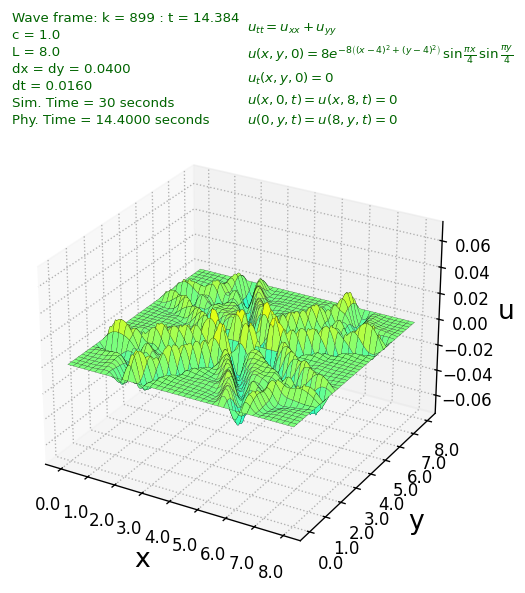

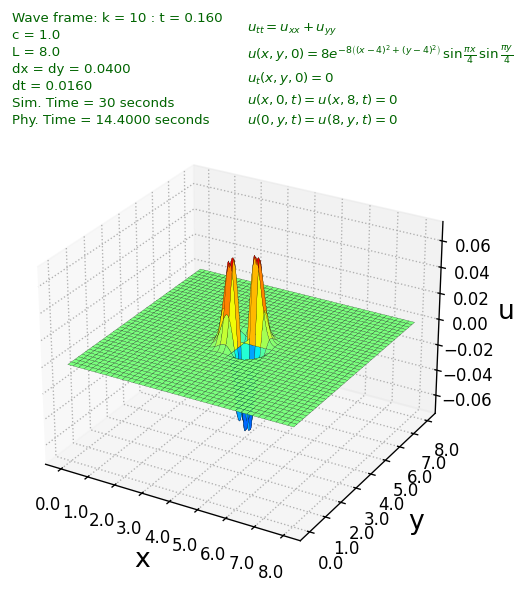

In [ ]:
PlotWaveFrame(10)   # Plot frame number k